# Joke Scorer Notebook
In this notebook we will attempt to develop and fine-tuen the joke scoring module of our network

## Import dependencies
Including loading any relevant packages and tools that we need

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
# Clone github repo for this project - takes some time
!git clone https://github.com/RyanJenkinson/nlp-jcag.git

Cloning into 'nlp-jcag'...
remote: Enumerating objects: 166, done.
remote: Total 166 (delta 0), reused 0 (delta 0), pack-reused 166
Receiving objects: 100% (166/166), 167.88 MiB | 6.26 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Checking out files: 100% (28/28), done.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import re
import sys
sys.path.append('nlp-jcag/scripts')
sys.path.append('nlp-jcag/data/raw_data')
sys.path.append('nlp-jcag/data/processed_data')

!apt install graphviz
!pip install pydot pydot-ng
from IPython.display import Image

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Lambda, Bidirectional, LSTM 
from keras.layers import Dropout, concatenate, GlobalMaxPooling1D, Activation 
from keras.layers import MaxPooling1D, Input, Conv1D
from keras.layers.normalization import BatchNormalization
from keras.backend import mean
from keras.utils import to_categorical, plot_model
from keras import optimizers, initializers, regularizers
from keras import backend as K

from sklearn import metrics
from sklearn.model_selection import train_test_split

from load_glove_embeddings import load_glove_embeddings

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


Using TensorFlow backend.


ModuleNotFoundError: ignored

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
#word2index, embedding_matrix = load_glove_embeddings('/content/gdrive/My Drive/glove.6B.300d.txt', embedding_dim=300)
word2index, embedding_matrix = load_glove_embeddings('/content/gdrive/My Drive/UCL/NLP/glove.6B.300d.txt', embedding_dim=300)

In [0]:
# Define some key metrics
def precision(y_true, y_pred):	
    """Precision metric.	
    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision

def recall(y_true, y_pred):	
    """Recall metric.	
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

def f1_score(y_true, y_pred):
    """Computes the F1 Score
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (2 * p * r) / (p + r + K.epsilon())

In [8]:
# Check that we are using a GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Let's get stuck in

In [0]:
def preprocess(words, to_lowercase=True, remove_punctuation=True, remove_digits=False, 
               remove_odd_chars=True, remove_stopwords=False, stem=False, spell_check=False,
               lemmatize=False):
    
    if to_lowercase:
        words = [w.lower() for w in words]
    
    if remove_punctuation:
        words = [w for w in words if not (re.match(r'^\W+$', w) != None)]
    
    if remove_digits:
        words = [w for w in words if not w.replace('.','',1).isdigit()]

    if remove_odd_chars:
        words = [re.sub(r'[^a-zA-Z0-9_]','', w) for w in words]
    
    if remove_stopwords:
        sw = set(nltk.corpus.stopwords.words("english"))
        words = [w for w in words if not w in sw]

    if spell_check:
        words = [str(TextBlob(w).correct()) for w in words]
     
    if stem:
        porter = nltk.PorterStemmer()
        words = [porter.stem(w) for w in words]

    if lemmatize:
        wordnet = nltk.WordNetLemmatizer()
        words = [wordnet.lemmatize(w) for w in words]
        
    return words

def lookup_index(docs):
    output_matrix = []
    for d in docs:
        indices = []
        for w in d:
            if w in word2index.keys():
                indices.append(word2index[w])
            else:
                indices.append(word2index['unk'])
        output_matrix.append(indices)
    return output_matrix

In [10]:
df = pd.read_csv('nlp-jcag/data/processed_data/jokes_dataset_CLEAN.csv')
df = df[['body','id','score','title']] # Keep relevant columns
df.head()

,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...
4,Because the p is silent.,5tz1o1,0,Why is it unknown on how pterodactyls urinate ...


The maximum length of the jokes in our dataset is: 70
We are doing categorical classification for our scoring model with 3 classes


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


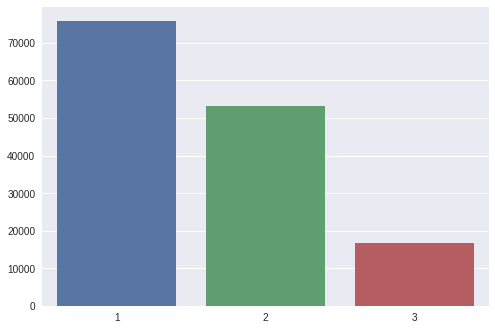

The class counts are: 
 1    75824
2    53258
3    16759
Name: class, dtype: int64


In [11]:
# Get the maximum length of the jokes in our dataset
MAX_JOKE_LENGTH = max([len((str(df.body[i]) + str(df.title[i])).split()) for i in range(len(df))])
print("The maximum length of the jokes in our dataset is:", MAX_JOKE_LENGTH)
      

# Decide if we are going to to categorical / regression
categorical = True
regression = 1 - categorical

# If we are doing categorical, define the number of classes
if categorical:
  num_classes = 3
  print('We are doing categorical classification for our scoring model with',
        num_classes,'classes')
  
  # We classify our jokes into categories:
  if num_classes == 2:
    # The classes are: 1 = Not funny, 2 = Funny
    t1 = 15
    df['class'] = [1 if df.score[i] <= t1 \
                   else 2 for i in range(df.shape[0])]

  if num_classes == 3:
    # The classes are: 1 = Not funny, 2 = Somewhat funny, 3 = Funny
    t1,t2 = 2,50
    df['class'] = [1 if df.score[i] <= t1 \
                   else 2 if (df.score[i] > t1 and df.score[i] <= t2) \
                   else 3 for i in range(df.shape[0])]
    
  # Plot the class counts
  class_counts = df['class'].value_counts()
  sns.barplot(class_counts.index, class_counts.values)
  plt.show()
  print("The class counts are: \n", class_counts)
    
if regression:
  print('We are doing regression for our scoring model')
  
  # Look at the distribution of jokes between a maximum and minimum score
  min_score = 2
  max_score = 2000
  df = df[(min_score <= df["score"]) & (df["score"] <= max_score)]
  
  map_score_range = [200,250] # This will define where we start thresholding our scores and using our mapping
  temp_df = df[(map_score_range[0] <= df["score"])] #& (df["score"] <= max_score)]

  # Map range using linear interpolation
  temp_df["score"] = (map_score_range[0] + (map_score_range[1] - map_score_range[0])*
                      ((temp_df["score"] - map_score_range[0]) / (max_score - map_score_range[0]))).astype('int') 

  # Combine the dataframe with jokes <= map_score_range[0] with the temp_df, sample them to "shuffle them" and reset index
  df = pd.concat([df.drop(temp_df.index),temp_df]).sample(frac=1).reset_index(drop=True)
  
  # For reference, plot a distribution of the score,as well as the distribution of the log scores
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  sns.distplot(df['score'], bins=50, kde=False, ax=axes[0])
  sns.distplot(np.power(df['score'] + 1, 1/4), bins=50, kde=False, ax=axes[1])
  
  # Reassign the score based on an appropriate transform
  df['score'] = np.power(df['score'] + 1, 1/4)

In [0]:
if categorical:
  # Get an even sample of the data
  even_sample = pd.DataFrame()
  # Round the smallest class down to the nearest thousand
  sample_size = min(class_counts)
  sample_size -= sample_size % 1000
  
  for i in range(1,num_classes+1):
    even_sample = pd.concat([even_sample, 
                             df[df['class'] == i].sample(sample_size)
                            ]).sample(frac=1)
    
  df_all = even_sample
if regression:
  df_all = df

NUM_RUNS = 3
df_trains = []
df_tests = []
y_trains = []
y_tests = []

for run in range(NUM_RUNS):
  # Split the data using train test split and reset the index
  df_train, df_test = train_test_split(df_all, test_size=0.2)
  df_train = df_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)

  # Get y values
  if categorical:
    y_train = df_train['class']
    y_test = df_test['class']

  if regression:
    y_train = df_train['score']
    y_test = df_test['score']
    
  df_trains.append(df_train)
  df_tests.append(df_test)
  y_trains.append(y_train)
  y_tests.append(y_test)

In [0]:
# Define a helper function to encode the jokes via GloVe
def encode_jokes(df):
  # Concatonate set-up and punchline
  docs = [str(df.title[i]) + ' ' + str(df.body[i]) for i in range(df.shape[0])]

  # Pre-process lowercasing, removing odd characters etc.
  docs_cleaned = [preprocess(words.split()) for words in docs]

  # Encode words using GloVe
  docs_encoded = lookup_index(docs_cleaned)
  
  # Pad sentences to max length, in our clean dataset this is 70
  docs_padded = pad_sequences(docs_encoded, maxlen=70, padding='post')
  
  return docs_padded

X_trains = []
X_tests = []

for run in range(NUM_RUNS):
  df_train = df_trains[run]
  df_test = df_tests[run]
  
  # Encode the jokes
  X_train = encode_jokes(df_train)
  X_test = encode_jokes(df_test)
  
  # Store the encodings
  X_trains.append(X_train)
  X_tests.append(X_test)

In [0]:
# Define number of models we will have for each class {BASELINE, ADVANCED}
NUM_MODELS_BASELINE = 5 
NUM_MODELS_ADVANCED = 1
NUM_MODELS_KIM = 6

# Define classes that contain a variety of models that we will run below

class BaselineModels:
  def __init__(self, model_num=0, reg_pen=0.0001):
    
    # Start by building the model
    self.model = Sequential()
   
    if (model_num == 0) or (model_num == 1):
      # Baseline Average Word/Bag of Words model
      self.name = "Average Word Model"
      embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1], 
              input_length=MAX_JOKE_LENGTH,
              weights=[embedding_matrix], 
              trainable=False,
              mask_zero=True, #set to true to ignore zeros in mean
              name='embedding_layer')
      self.model.add(embedding_layer)
      # Word averaging where now we're masking the zeros
      self.model.add(Lambda(lambda x: mean(x, axis=1)))

      if model_num == 1:
        self.name = "Average Word Model + NN"
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
    else:
      embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1], 
              input_length=MAX_JOKE_LENGTH,
              weights=[embedding_matrix], 
              trainable=False,
              mask_zero=False,#set to true to ignore zeros in mean
              name='embedding_layer')
      self.model.add(embedding_layer)
    if (model_num == 2) or (model_num == 3):
      # Basic Flatten model
      self.name = "Concatenated Words / Flatten"
      self.model.add(Flatten())

      if model_num == 3:
        self.name = "Flatten + NN"
        self.model.add(Dense(1024, activation='relu'))
        self.model.add(Dense(512, activation='relu'))
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))

    if model_num == 4:
      # Basic CNN model
      num_filters = 32
      self.name = "Basic CNN [" + str(num_filters) + \
                  " filters, Kernel size 3 and Max Pool]"
      self.model.add(Conv1D(filters=num_filters, 
                            kernel_size=3, activation='relu'))
      self.model.add(GlobalMaxPooling1D())

    if model_num == 5:
      # Basic LSTM Model
      self.name = "Basic LSTM w/ 32 dim Hidden Layer"
      self.model.add(LSTM(512))
      self.model.add(Dense(32, activation='relu'))

    # Final layer for prediction
    if categorical:
      self.model.add(Dense(num_classes, activation='softmax'))
      
    if regression:
      self.model.add(Dense(1))

  def get_name(self):
    return self.name

  def compile(self,optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc', precision, recall, f1_score]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def summary(self):
    return self.model.summary()

  def fit(self, X_train, y_train, validation_split=0.3, batch_size=32, epochs=10, verbose=2):
    self.model.fit(X_train, y_train, validation_split=validation_split,
                      batch_size=batch_size, epochs=epochs,verbose=verbose)

  def predict_classes(self,X_test):
    return self.model.predict_classes(X_test)

###############################################################################
class AdvancedModels:
  def __init__(self, model_num=0, reg_pen=0.0001):
    self.use_functional_API = False
    
    if model_num == 0:
      # Implement Kim (2014) CNN-like model
      self.name = "Kim (2014)"
      self.use_functional_API = True
      # Code below is similar to:
      # www.kaggle.com/danielsafai/cnn-implementation-of-yoon-kim-s-model
      input_layer = Input(shape=(X_train.shape[1],), dtype='int64')
      embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1], 
              input_length=MAX_JOKE_LENGTH,
              weights=[embedding_matrix], 
              trainable=False,
              mask_zero=False, # Conv1D does not support masking : (
              name='embedding_layer')(input_layer)
      
      num_filters = 128 # Number of filters to use for each convolution
      dropout_rate = 0.2

      # Specify each convolution layer and their kernel size i.e. n-grams 
      # For this model we use Keras' Functional API as we're doing a max pool
      # across time...
      conv1_1 = Conv1D(filters=num_filters, kernel_size=3)(embedding_layer)
      btch1_1 = BatchNormalization()(conv1_1)
      drp1_1  = Dropout(rate=dropout_rate)(btch1_1)
      actv1_1 = Activation('relu')(drp1_1)
      glmp1_1 = GlobalMaxPooling1D()(actv1_1)

      conv1_2 = Conv1D(filters=num_filters, kernel_size=4)(embedding_layer)
      btch1_2 = BatchNormalization()(conv1_2)
      drp1_2  = Dropout(rate=dropout_rate)(btch1_2)
      actv1_2 = Activation('relu')(drp1_2)
      glmp1_2 = GlobalMaxPooling1D()(actv1_2)

      conv1_3 = Conv1D(filters=num_filters, kernel_size=5)(embedding_layer)
      btch1_3 = BatchNormalization()(conv1_3)
      drp1_3  = Dropout(rate=dropout_rate)(btch1_3)
      actv1_3 = Activation('relu')(drp1_3)
      glmp1_3 = GlobalMaxPooling1D()(actv1_3)

      conv1_4 = Conv1D(filters=num_filters, kernel_size=6)(embedding_layer)
      btch1_4 = BatchNormalization()(conv1_4)
      drp1_4  = Dropout(rate=dropout_rate)(btch1_4)
      actv1_4 = Activation('relu')(drp1_4)
      glmp1_4 = GlobalMaxPooling1D()(actv1_4)

      # Concatenate all convolution layers
      concat = concatenate([glmp1_1, glmp1_2, glmp1_3, glmp1_4], axis=1)
      drp1 = Dropout(rate=dropout_rate)(concat)

      fc1  = Dense(32, activation='relu')(drp1)
      btch1 = BatchNormalization()(fc1)
      drp2  = Dropout(rate=dropout_rate)(btch1)
      
      if categorical:
        output_layer = Dense(num_classes, activation='softmax')(drp2)
      if regression:
        output_layer = Dense(1)(drp2)
      
      self.model = Model(inputs=input_layer, outputs=output_layer)
   
    # TODO - ADD ADVANCED MODELS
    if model_num == 1:
      self.name = "Stacked LSTM"
      # Start by building the model
      self.model = Sequential()
      
      data_dim = 300
      timesteps = MAX_JOKE_LENGTH
      
      embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1], 
              input_length=MAX_JOKE_LENGTH,
              weights=[embedding_matrix], 
              trainable=False,
              mask_zero=False,
              name='embedding_layer')
      
      self.model.add(embedding_layer)
      # expected input data shape: (batch_size, timesteps, data_dim)
      self.model.add(LSTM(512, return_sequences=True,
                          input_shape=(timesteps, data_dim)))
      self.model.add(LSTM(128, return_sequences=True))
      self.model.add(LSTM(32))  # return a single vector
    
    # Final layer for prediction
    if categorical and not self.use_functional_API:
      self.model.add(Dense(num_classes, activation='softmax'))
      
    if regression and not self.use_functional_API:
      self.model.add(Dense(1))

  def get_name(self):
    return self.name

  def compile(self,optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc', precision, recall, f1_score]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def summary(self):
    return self.model.summary()

  def fit(self, X_train, y_train, validation_split=0.3, batch_size=32, epochs=10):
    self.model.fit(X_train, y_train, validation_split=validation_split,
                      batch_size=batch_size, epochs=epochs)

  def predict_classes(self,X_test):
    if self.use_functional_API:
      y_probs = self.model.predict(X_test) 
      return y_probs.argmax(axis=-1)
    else:
      return self.model.predict_classes(X_test)
    
###############################################################################
class KimModels:
  def __init__(self, model_num=0, num_filters=128, dropout_rate=0.2, num_hidden=32):
    self.use_functional_API = False
    
    # Implement Kim (2014) CNN-like model
    self.name = "Kim (2014)"
    self.use_functional_API = True
    # Code below is similar to:
    # www.kaggle.com/danielsafai/cnn-implementation-of-yoon-kim-s-model
    input_layer = Input(shape=(X_train.shape[1],), dtype='int64')
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1], 
            input_length=MAX_JOKE_LENGTH,
            weights=[embedding_matrix], 
            trainable=False,
            mask_zero=False, # Conv1D does not support masking : (
            name='embedding_layer')(input_layer)

    # Specify each convolution layer and their kernel size i.e. n-grams 
    # For this model we use Keras' Functional API as we're doing a max pool
    # across time...
    if model_num >= 0:
      conv1_1 = Conv1D(filters=num_filters, kernel_size=3)(embedding_layer)
      btch1_1 = BatchNormalization()(conv1_1)
      drp1_1  = Dropout(rate=dropout_rate)(btch1_1)
      actv1_1 = Activation('relu')(drp1_1)
      glmp1_1 = GlobalMaxPooling1D()(actv1_1)
    
      if model_num >= 1:
        conv1_2 = Conv1D(filters=num_filters, kernel_size=4)(embedding_layer)
        btch1_2 = BatchNormalization()(conv1_2)
        drp1_2  = Dropout(rate=dropout_rate)(btch1_2)
        actv1_2 = Activation('relu')(drp1_2)
        glmp1_2 = GlobalMaxPooling1D()(actv1_2)
        
        if model_num >= 2:
          conv1_3 = Conv1D(filters=num_filters, kernel_size=5)(embedding_layer)
          btch1_3 = BatchNormalization()(conv1_3)
          drp1_3  = Dropout(rate=dropout_rate)(btch1_3)
          actv1_3 = Activation('relu')(drp1_3)
          glmp1_3 = GlobalMaxPooling1D()(actv1_3)
          
          if model_num >= 3:
            conv1_4 = Conv1D(filters=num_filters, kernel_size=6)(embedding_layer)
            btch1_4 = BatchNormalization()(conv1_4)
            drp1_4  = Dropout(rate=dropout_rate)(btch1_4)
            actv1_4 = Activation('relu')(drp1_4)
            glmp1_4 = GlobalMaxPooling1D()(actv1_4)
            
            if model_num >= 4:
              conv1_5 = Conv1D(filters=num_filters, kernel_size=7)(embedding_layer)
              btch1_5 = BatchNormalization()(conv1_5)
              drp1_5  = Dropout(rate=dropout_rate)(btch1_5)
              actv1_5 = Activation('relu')(drp1_5)
              glmp1_5 = GlobalMaxPooling1D()(actv1_5)
              
              if model_num >= 5:
                conv1_6 = Conv1D(filters=num_filters, kernel_size=8)(embedding_layer)
                btch1_6 = BatchNormalization()(conv1_6)
                drp1_6  = Dropout(rate=dropout_rate)(btch1_6)
                actv1_6 = Activation('relu')(drp1_6)
                glmp1_6 = GlobalMaxPooling1D()(actv1_6)

      # Concatenate all convolution layers
      if model_num == 0:
        concat = glmp1_1
        
      elif model_num == 1:
        concat = concatenate([glmp1_1, glmp1_2], axis=1)
        
      elif model_num == 2:
        concat = concatenate([glmp1_1, glmp1_2, glmp1_3], axis=1)
        
      elif model_num == 3:
        concat = concatenate([glmp1_1, glmp1_2, glmp1_3, glmp1_4], axis=1)
        
      elif model_num == 4:
        concat = concatenate([glmp1_1, glmp1_2, glmp1_3, glmp1_4, glmp1_5], axis=1)
        
      elif model_num == 5:
        concat = concatenate([glmp1_1, glmp1_2, glmp1_3, glmp1_4, glmp1_5, glmp1_6], axis=1)
      
    drp1 = Dropout(rate=dropout_rate)(concat)

    fc1  = Dense(num_hidden, activation='relu')(drp1)
    btch1 = BatchNormalization()(fc1)
    drp2  = Dropout(rate=dropout_rate)(btch1)

    if categorical:
      output_layer = Dense(num_classes, activation='softmax')(drp2)
    if regression:
      output_layer = Dense(1)(drp2)

    self.model = Model(inputs=input_layer, outputs=output_layer)
      
    # Final layer for prediction
    if categorical and not self.use_functional_API:
      self.model.add(Dense(num_classes, activation='softmax'))
      
    if regression and not self.use_functional_API:
      self.model.add(Dense(1))

  def get_name(self):
    return self.name

  def compile(self,optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc', precision, recall, f1_score]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def summary(self):
    return self.model.summary()

  def fit(self, X_train, y_train, validation_split=0.3, batch_size=32, epochs=10,verbose=2):
    self.model.fit(X_train, y_train, validation_split=validation_split,
                      batch_size=batch_size, epochs=epochs,verbose=verbose)

  def predict_classes(self,X_test):
    if self.use_functional_API:
      y_probs = self.model.predict(X_test) 
      return y_probs.argmax(axis=-1)
    else:
      return self.model.predict_classes(X_test)

## Run Baseline Models and Output results

---------------- Run Number: 0 ----------------
---------------- Training Model: Average Word Model ----------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 70, 300)           120000300 
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 120,001,203
Trainable params: 903
Non-trainable params: 120,000,300
_________________________________________________________________
None


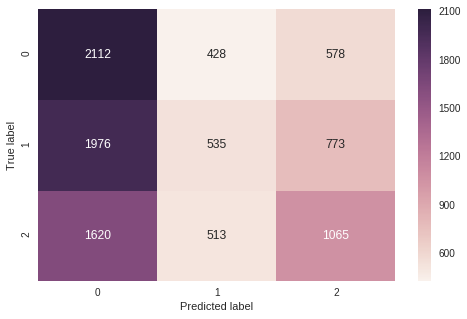

---------------- Training Model: Average Word Model + NN ----------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 70, 300)           120000300 
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 120,049,263
Trainable params: 48,963
Non-trainable par

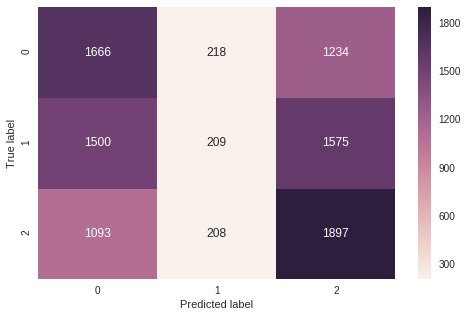

---------------- Training Model: Concatenated Words / Flatten ----------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 70, 300)           120000300 
_________________________________________________________________
flatten_1 (Flatten)          (None, 21000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63003     
Total params: 120,063,303
Trainable params: 63,003
Non-trainable params: 120,000,300
_________________________________________________________________
None


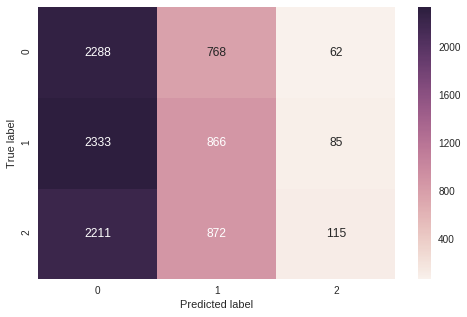

---------------- Training Model: Flatten + NN ----------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 70, 300)           120000300 
_________________________________________________________________
flatten_1 (Flatten)          (None, 21000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              21505024  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dens

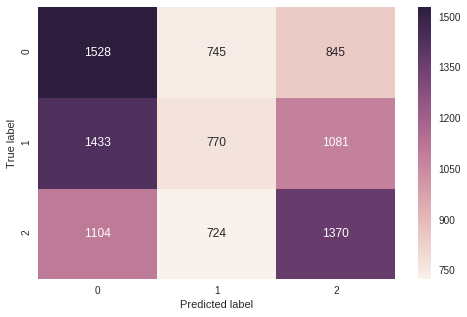

---------------- Training Model: Basic CNN [32 filters, Kernel size 3 and Max Pool] ----------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 70, 300)           120000300 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 68, 32)            28832     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 120,029,231
Trainable params: 28,931
Non-trainable params: 120,000,300
_________________________________________________________________
None


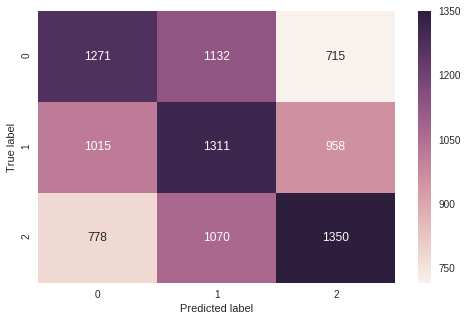

---------------- Run Number: 1 ----------------
---------------- Training Model: Average Word Model ----------------
---------------- Training Model: Average Word Model + NN ----------------
---------------- Training Model: Concatenated Words / Flatten ----------------
---------------- Training Model: Flatten + NN ----------------
---------------- Training Model: Basic CNN [32 filters, Kernel size 3 and Max Pool] ----------------
---------------- Run Number: 2 ----------------
---------------- Training Model: Average Word Model ----------------
---------------- Training Model: Average Word Model + NN ----------------
---------------- Training Model: Concatenated Words / Flatten ----------------
---------------- Training Model: Flatten + NN ----------------
---------------- Training Model: Basic CNN [32 filters, Kernel size 3 and Max Pool] ----------------
---------------- Run Number: 3 ----------------
---------------- Training Model: Average Word Model ----------------
---------------

In [23]:
# Define some hyperparameters
VAL_SPLIT = 0.2
NUM_EPOCHS = 20
BATCH_SIZE = 32
results_dfs = []

for run in range(NUM_RUNS):
  print('---------------- Run Number:',run,'----------------')
  X_train = X_trains[run]
  y_train = y_trains[run]
  X_test = X_tests[run]
  y_test = y_tests[run]
  
  # Create the results dataframe
  results_df = pd.DataFrame()
  
  for model_num in range(NUM_MODELS_BASELINE):
    # Clear session to avoid memory issues
    K.clear_session()

    # After clearing the session we need to redefine the optimiser
    adam = optimizers.adam(lr=0.001)

    # Get our model
    model = BaselineModels(model_num=model_num)
    print('---------------- Training Model:',model.get_name(),'----------------')

    if categorical:
      # Compile model and print summary
      model.compile(optimizer=adam, loss='categorical_crossentropy', 
                  metrics=['acc', precision, recall, f1_score])
      if run is 0:
        print(model.summary())

      # Use y_train - 1 to map {1,2,3} -> {0,1,2} and one hot the vectors
      model.fit(X_train, to_categorical(y_train - 1), validation_split=VAL_SPLIT, 
                batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=0)

      # Map predictions of {0,1,2} -> {1,2,3}, and plot confusion matrix
      y_preds = model.predict_classes(X_test) + 1
      #y_test = df_test['class']
#       if model_num == 0:
#         # Save results to drive for further analysis for BoW Model
#         df_train.to_csv('/content/gdrive/My Drive/UCL/NLP/BoW_df_train.csv')
#         pd.concat([df_test,pd.DataFrame(y_preds, columns=['predictions'])], axis=1).to_csv('/content/gdrive/My Drive/UCL/NLP/BoW_df_test.csv')
      if run is 0:
        cm = metrics.confusion_matrix(y_test, y_preds)

        plt.figure(figsize = (8,5))
        sns.heatmap(cm, annot=True,fmt='g')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    # Plot results
    if regression:
      # Compile model and print summary
      model.compile(optimizer=adam, loss='mean_squared_error')
      print(model.summary())

      # Fit regression model
      model.fit(X_train, y_train, validation_split=VAL_SPLIT, 
                  batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

      # Make predictions and output plots
      y_preds = model.predict(X_test).squeeze()
      sns.regplot(x=y_test,y=y_preds)
      plt.ylabel('True score')
      plt.xlabel('Predicted score')
      plt.show()

      from scipy.stats import linregress
      print(linregress(y_test, y_preds))

    # Store values for output table to compare results
    num_DP = 3 # Number of decimal places to round numbers below to
    if categorical:
      results_df = results_df.append({'Model Name': model.get_name(),
                                      'Accuracy': np.around(metrics.accuracy_score(y_test,y_preds),num_DP),
                                      'Precision': np.around(metrics.precision_score(y_test,y_preds, average=None),num_DP),
                                      'Recall': np.around(metrics.recall_score(y_test,y_preds, average=None),num_DP),
                                      'F1 Score': np.around(metrics.f1_score(y_test,y_preds, average=None),num_DP)},
                                     ignore_index=True)
    if regression:
      results_df = results_df.append({'Model Name': model.get_name(),
                                      'MSE': np.around(metrics.mean_squared_error(y_test,y_preds),num_DP)},
                                     ignore_index=True)
  
  # Reorder the columns
  if categorical:
    results_df = results_df[['Model Name','Accuracy','Precision','Recall','F1 Score']]
  if regression:
    results_df = results_df[['Model Name','MSE']]
    
  # Save the results dataframe to a list
  results_dfs.append(results_df)

## Implement "Advanced" Models

---------------- Run Number: 0 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


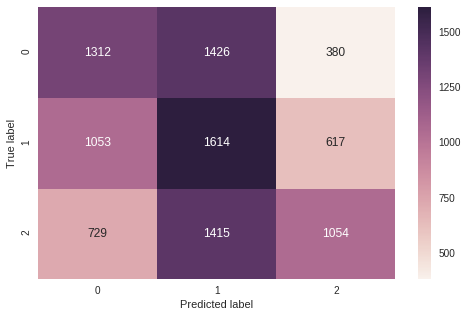

---------------- Run Number: 1 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


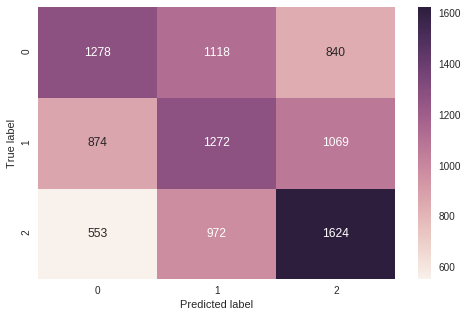

---------------- Run Number: 2 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


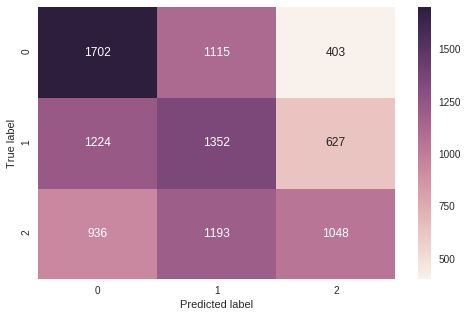

---------------- Run Number: 3 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


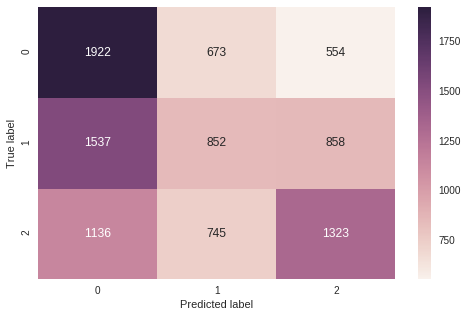

---------------- Run Number: 4 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


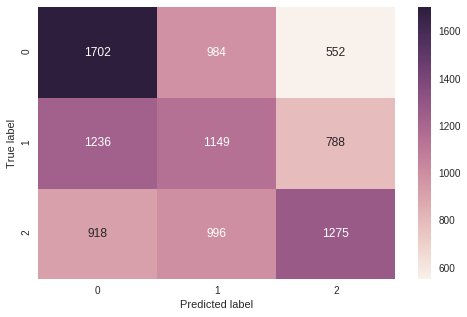

---------------- Run Number: 5 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


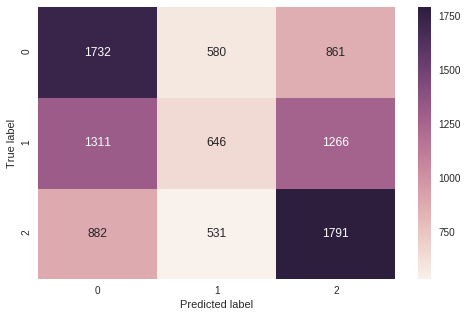

---------------- Run Number: 6 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


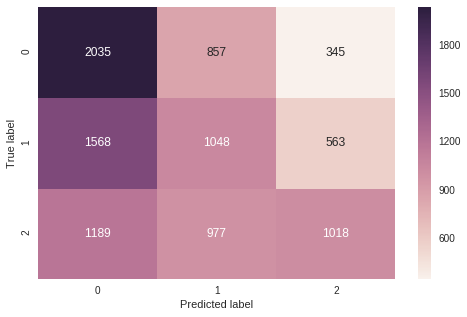

---------------- Run Number: 7 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


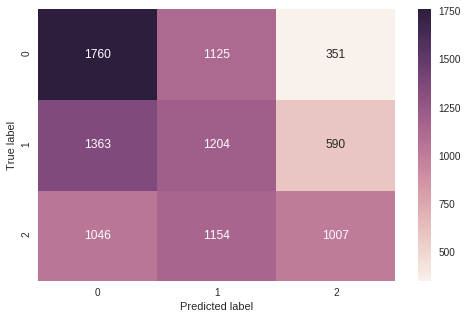

---------------- Run Number: 8 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


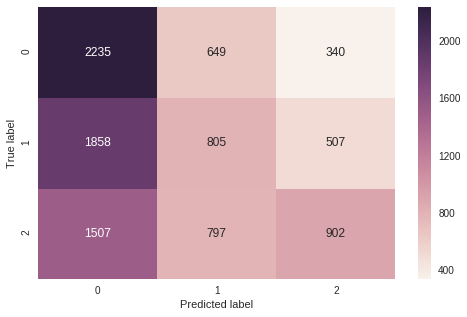

---------------- Run Number: 9 ----------------
---------------- Training Model: Kim (2014) ----------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 70, 300)      120000300   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 68, 128)      115328      embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 67, 128)      153728      embedding_layer[0][0]            


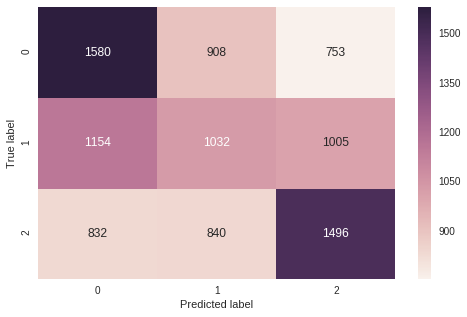

In [33]:
#results_dfs = []

# Define some hyperparameters
VAL_SPLIT = 0.2
NUM_EPOCHS = 10
BATCH_SIZE = 32
for run in range(NUM_RUNS):
  print('---------------- Run Number:',run,'----------------')
  X_train = X_trains[run]
  y_train = y_trains[run]
  X_test = X_tests[run]
  y_test = y_tests[run]
  # Create the results dataframe
  results_df = pd.DataFrame()
  for model_num in range(NUM_MODELS_ADVANCED):
    # Clear session to avoid memory issues
    K.clear_session()

    # After clearing the session we need to redefine the optimiser
    adam = optimizers.adam(lr=0.001)

    # Get our model
    model = AdvancedModels(model_num=model_num)
    print('---------------- Training Model:',model.get_name(),'----------------')

    if categorical:
      # Compile model and print summary
      model.compile(optimizer=adam, loss='categorical_crossentropy', 
                  metrics=['acc', precision, recall, f1_score])
      print(model.summary())

#       if model_num == 0:
#         # Save Kim Model graph to output for report
#         plot_model(model, show_shapes=True, show_layer_names=True, 
#                    to_file='/content/gdrive/My Drive/UCL/NLP/Kim_Model_Graph.png')
#         Image(retina=True, filename='/content/gdrive/My Drive/UCL/NLP/Kim_Model_Graph.png')

      # Use y_train - 1 to map {1,2,3} -> {0,1,2} and one hot the vectors
      model.fit(X_train, to_categorical(y_train - 1), validation_split=VAL_SPLIT, 
                batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

      # Map predictions of {0,1,2} -> {1,2,3}, and plot confusion matrix
      y_preds = model.predict_classes(X_test) + 1
      #y_test = df_test['class']

      cm = metrics.confusion_matrix(y_test, y_preds)

      plt.figure(figsize = (8,5))
      sns.heatmap(cm, annot=True,fmt='g')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()

    # Plot results
    if regression:
      # Compile model and print summary
      model.compile(optimizer=adam, loss='mean_squared_error')
      print(model.summary())

      # Fit regression model
      model.fit(X_train, y_train,validation_split=0.3, batch_size=30, epochs=10)

      # Make predictions and output plots
      y_preds = model.predict(X_test).squeeze()
      sns.regplot(x=y_test,y=y_preds)
      plt.ylabel('True score')
      plt.xlabel('Predicted score')
      plt.show()

      from scipy.stats import linregress
      print(linregress(y_test, y_preds))

    # Store values for output table to compare results
    num_DP = 3 # Number of decimal places to round numbers below to
    if categorical:
      results_df = results_df.append({'Model Name': model.get_name(),
                                      'Accuracy': np.around(metrics.accuracy_score(y_test,y_preds),num_DP),
                                      'Precision': np.around(metrics.precision_score(y_test,y_preds, average=None),num_DP),
                                      'Recall': np.around(metrics.recall_score(y_test,y_preds, average=None),num_DP),
                                      'F1 Score': np.around(metrics.f1_score(y_test,y_preds, average=None),num_DP)},
                                     ignore_index=True)
    if regression:
      results_df = results_df.append({'Model Name': model.get_name(),
                                      'MSE': np.around(metrics.mean_squared_error(y_test,y_preds),num_DP)},
                                     ignore_index=True)
  
  # Reorder the columns
  if categorical:
    results_df = results_df[['Model Name','Accuracy','Precision','Recall','F1 Score']]
  if regression:
    results_df = results_df[['Model Name','MSE']]
  
  # Save the results dataframe to a list
  results_dfs.append(results_df)

In [0]:
#results_dfs = results_dfs[0:10]

                                                    Mean Accuracy       Std
Model Name                                                                 
Average Word Model                                         0.3922  0.003853
Average Word Model + NN                                    0.3910  0.009286
Basic CNN [32 filters, Kernel size 3 and Max Pool]         0.4005  0.005212
Concatenated Words / Flatten                               0.3668  0.014589
Flatten + NN                                               0.3785  0.008127
Kim (2014)                                                 0.4248  0.008456


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


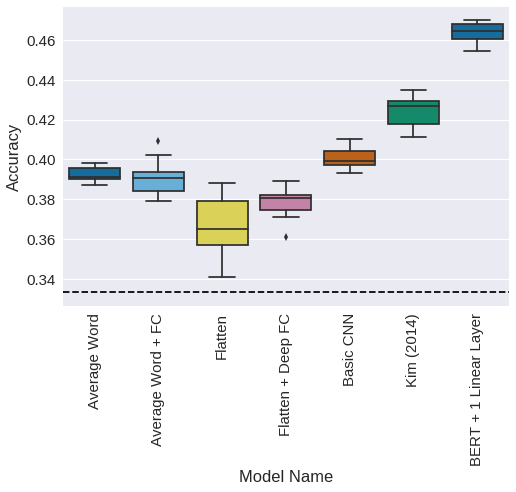

In [19]:
with open('/content/gdrive/My Drive/UCL/NLP/results_dfs.pickle', 'rb') as handle:
    results_dfs = pickle.load(handle)
    
df_concat = pd.concat(results_dfs)
df_concat = df_concat[['Model Name','Accuracy']]
df_results_final = df_concat.groupby(df_concat['Model Name']).mean()
df_results_final = pd.concat([df_results_final,
                             df_concat.groupby(df_concat['Model Name']).std()], axis=1)
#df_results_final[list(df_results_final.columns) + " (Std) "] = df_concat.groupby(df_concat.index).std()
# df.select_dtypes(include=[np.number]).columns.tolist()

df_results_final.columns = ['Mean Accuracy', 'Std']

print(df_results_final)
#df_results_final['Mean Accuracy'].plot(yerr=df_results_final['Std'], kind='box')


# Show BERT Model results
with open('/content/gdrive/My Drive/UCL/NLP/bert_accuracy.pickle', 'rb') as handle:
    bert_results = pickle.load(handle)
   
# Extract accuracies from the pickle file and plot
bert_accs = [res[0]['eval_accuracy'] for res in bert_results] 
df_results_final.append(pd.DataFrame({'Mean Accuracy': np.mean(bert_accs),
                                      'Std': np.std(bert_accs)}, index=['BERT']))
df_concat = pd.concat([df_concat, pd.DataFrame({'Model Name': ['BERT' for _ in bert_accs],
                                                'Accuracy': bert_accs}, columns=['Model Name','Accuracy'])])

sns.set_style('whitegrid')                     
sns.set(font_scale=1.5)                     
sns.boxplot(y="Accuracy", x="Model Name", data=df_concat[::-1], palette='colorblind')

plt.xticks(range(7),['BERT + 1 Linear Layer','Kim (2014)','Basic CNN',
                     'Flatten + Deep FC','Flatten','Average Word + FC',
                     'Average Word'], rotation='vertical')

plt.xlim((6.5,-.5))
plt.axhline(y=1/3, color='k', linestyle='--')

plt.savefig('/content/gdrive/My Drive/UCL/NLP/BasicModelsResults_flipped.png',
           bbox_inches='tight')

# with open('/content/gdrive/My Drive/UCL/NLP/results_dfs.pickle', 'wb') as handle:
#     pickle.dump(results_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
np.mean(bert_accs)

0.46383253

### Perform Hyperparameter Tuning on the Kim Model

In [0]:
# Perform Hyperparameter Tuning on Kim Model
# Define some hyperparameters
VAL_SPLIT = 0.2
NUM_EPOCHS = 10
BATCH_SIZE = 32
results_dfs = []

import itertools # This will be helpful to iterate over all combinations!

for run in range(NUM_RUNS):
  print('---------------- Run Number:',run,'----------------')
  X_train = X_trains[run]
  y_train = y_trains[run]
  X_test = X_tests[run]
  y_test = y_tests[run]
  
  # Create the results dataframe
  results_df = pd.DataFrame()
  
  for model_num in range(0,NUM_MODELS_KIM):
    for lr,dr,num_filters,num_hidden in list(itertools.product([0.01,0.001],
                                                               [0.0,0.1,0.25],
                                                               [64,128,256],
                                                               [32,64,128])):
      # Clear session to avoid memory issues
      K.clear_session()

      # After clearing the session we need to redefine the optimiser
      adam = optimizers.adam(lr=lr)

      # Get our model
      model = KimModels(model_num=model_num,num_filters=num_filters,dropout_rate=dr,num_hidden=num_hidden)
      print('---------------- Training Model:','_'.join([model.get_name(),str(model_num),str(lr),str(dr),str(num_filters),str(num_hidden)]),'----------------')

      if categorical:
        # Compile model and print summary
        model.compile(optimizer=adam, loss='categorical_crossentropy', 
                    metrics=['acc', precision, recall, f1_score])
#         if run is 0:
#           print(model.summary())

        # Use y_train - 1 to map {1,2,3} -> {0,1,2} and one hot the vectors
        model.fit(X_train, to_categorical(y_train - 1), validation_split=VAL_SPLIT, 
                  batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=0)

        # Map predictions of {0,1,2} -> {1,2,3}, and plot confusion matrix
        y_preds = model.predict_classes(X_test) + 1
        #y_test = df_test['class']
  #       if model_num == 0:
  #         # Save results to drive for further analysis for BoW Model
  #         df_train.to_csv('/content/gdrive/My Drive/UCL/NLP/BoW_df_train.csv')
  #         pd.concat([df_test,pd.DataFrame(y_preds, columns=['predictions'])], axis=1).to_csv('/content/gdrive/My Drive/UCL/NLP/BoW_df_test.csv')
#         if run is 0:
#           cm = metrics.confusion_matrix(y_test, y_preds)

#           plt.figure(figsize = (8,5))
#           sns.heatmap(cm, annot=True,fmt='g')
#           plt.ylabel('True label')
#           plt.xlabel('Predicted label')
#           plt.show()

      # Plot results
      if regression:
        # Compile model and print summary
        model.compile(optimizer=adam, loss='mean_squared_error')
        print(model.summary())

        # Fit regression model
        model.fit(X_train, y_train, validation_split=VAL_SPLIT, 
                    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

        # Make predictions and output plots
        y_preds = model.predict(X_test).squeeze()
        sns.regplot(x=y_test,y=y_preds)
        plt.ylabel('True score')
        plt.xlabel('Predicted score')
        plt.show()

        from scipy.stats import linregress
        print(linregress(y_test, y_preds))

      # Store values for output table to compare results
      num_DP = 3 # Number of decimal places to round numbers below to
      if categorical:
        results_df = results_df.append({'Model Name': '_'.join([model.get_name(),str(model_num),str(lr),str(dr),str(num_filters)]),
                                        'Accuracy': np.around(metrics.accuracy_score(y_test,y_preds),num_DP),
                                        'Precision': np.around(metrics.precision_score(y_test,y_preds, average=None),num_DP),
                                        'Recall': np.around(metrics.recall_score(y_test,y_preds, average=None),num_DP),
                                        'F1 Score': np.around(metrics.f1_score(y_test,y_preds, average=None),num_DP)},
                                       ignore_index=True)
      if regression:
        results_df = results_df.append({'Model Name': model.get_name(),
                                        'MSE': np.around(metrics.mean_squared_error(y_test,y_preds),num_DP)},
                                       ignore_index=True)

      # Reorder the columns
      if categorical:
        results_df = results_df[['Model Name','Accuracy','Precision','Recall','F1 Score']]
      if regression:
        results_df = results_df[['Model Name','MSE']]

      # Save the results dataframe to a list
      results_dfs.append(results_df)

      # Save as we go in case it crashes or whatever
      with open('/content/gdrive/My Drive/UCL/NLP/Kim_results_dfs_0onwards.pickle', 'wb') as handle:
        pickle.dump(results_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

---------------- Run Number: 0 ----------------
---------------- Training Model: Kim (2014)_0_0.01_0.0_64_32 ----------------
---------------- Training Model: Kim (2014)_0_0.01_0.0_64_64 ----------------
---------------- Training Model: Kim (2014)_0_0.01_0.0_64_128 ----------------
---------------- Training Model: Kim (2014)_0_0.01_0.0_128_32 ----------------


In [0]:
with open('/content/gdrive/My Drive/UCL/NLP/Kim_results_dfs.pickle', 'wb') as handle:
    pickle.dump(results_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
df_concat = pd.concat(results_dfs)
df_results_final = df_concat.groupby(df_concat['Model Name']).mean()
df_results_final = pd.concat([df_results_final,
                             df_concat.groupby(df_concat['Model Name']).std()], axis=1)
#df_results_final[list(df_results_final.columns) + " (Std) "] = df_concat.groupby(df_concat.index).std()
# df.select_dtypes(include=[np.number]).columns.tolist()

df_results_final.columns = ['Mean Accuracy', 'Std']

print(df_results_final)
#df_results_final['Mean Accuracy'].plot(yerr=df_results_final['Std'], kind='box')

sns.set_style('whitegrid')

sns.boxplot(x="Accuracy", y="Model Name", data=df_concat, palette='colorblind')
plt.yticks(range(len(df_results_final)),['Average Word','Average Word + NN','Concatenated Words / Flatten',
           'Flatten + NN', 'Basic CNN [32 Filters, Kernel Size 3 + Max Pool]',
                     'Kim (2014) [No Hyperparameter/Layer Tuning]',
                     'Average Word BERT + 1 Linear Layer'])

# 0.4607 - BERT with 1 linear layer
sns.regplot(x=np.array([0.4607]), y=np.array([len(df_results_final)]), scatter=True, fit_reg=False, marker='x',
            scatter_kws={"s": 100}, color='k')

plt.ylim((6.5,-.5))
plt.savefig('/content/gdrive/My Drive/UCL/NLP/KimModelsResults.png',
           bbox_inches='tight')



In [0]:
# Get graph of best performing Kim Model
input_layer = Input(shape=(X_train.shape[1],), dtype='int64')
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1], 
        input_length=MAX_JOKE_LENGTH,
        weights=[embedding_matrix], 
        trainable=False,
        mask_zero=False, # Conv1D does not support masking : (
        name='embedding_layer')(input_layer)

num_filters = 128 # Number of filters to use for each convolution
dropout_rate = 0.2

# Specify each convolution layer and their kernel size i.e. n-grams 
# For this model we use Keras' Functional API as we're doing a max pool
# across time...
conv1_1 = Conv1D(filters=num_filters, kernel_size=3)(embedding_layer)
btch1_1 = BatchNormalization()(conv1_1)
drp1_1  = Dropout(rate=dropout_rate)(btch1_1)
actv1_1 = Activation('relu')(drp1_1)
glmp1_1 = GlobalMaxPooling1D()(actv1_1)

conv1_2 = Conv1D(filters=num_filters, kernel_size=4)(embedding_layer)
btch1_2 = BatchNormalization()(conv1_2)
drp1_2  = Dropout(rate=dropout_rate)(btch1_2)
actv1_2 = Activation('relu')(drp1_2)
glmp1_2 = GlobalMaxPooling1D()(actv1_2)

conv1_3 = Conv1D(filters=num_filters, kernel_size=5)(embedding_layer)
btch1_3 = BatchNormalization()(conv1_3)
drp1_3  = Dropout(rate=dropout_rate)(btch1_3)
actv1_3 = Activation('relu')(drp1_3)
glmp1_3 = GlobalMaxPooling1D()(actv1_3)

conv1_4 = Conv1D(filters=num_filters, kernel_size=6)(embedding_layer)
btch1_4 = BatchNormalization()(conv1_4)
drp1_4  = Dropout(rate=dropout_rate)(btch1_4)
actv1_4 = Activation('relu')(drp1_4)
glmp1_4 = GlobalMaxPooling1D()(actv1_4)

# Concatenate all convolution layers
concat = concatenate([glmp1_1, glmp1_2, glmp1_3, glmp1_4], axis=1)
drp1 = Dropout(rate=dropout_rate)(concat)

fc1  = Dense(32, activation='relu')(drp1)
btch1 = BatchNormalization()(fc1)
drp2  = Dropout(rate=dropout_rate)(btch1)

if categorical:
  output_layer = Dense(num_classes, activation='softmax')(drp2)
if regression:
  output_layer = Dense(1)(drp2)

model = Model(inputs=input_layer, outputs=output_layer)

plot_model(model, show_shapes=False, show_layer_names=False,
           to_file='/content/gdrive/My Drive/UCL/NLP/Kim_Model_Graph.png')
Image(retina=True, filename='/content/gdrive/My Drive/UCL/NLP/Kim_Model_Graph.png')